In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
!! unzip data.zip

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [7]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [38]:
def make_dictionary(all_codones):
    unique_codones, counts = np.unique(np.array(flatten(all_codones)), return_counts=True)
    dictionary = {cod: i for i, cod in enumerate(unique_codones[np.argsort(-counts)])}
    return dictionary

In [39]:
dictionary = make_dictionary(all_codones)

In [41]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:
######################

In [128]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            first_embed = tf.Variable(tf.random_uniform([self.vocab_size, 100], -1.0, 1.0))

            weight = tf.Variable(tf.truncated_normal([100, self.embed_size], stddev=0.05))
            bias = tf.Variable(tf.truncated_normal([self.embed_size], stddev=0.05))

            self.embed_matrix = tf.nn.xw_plus_b(first_embed, weight, bias)

    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss,
                                                                                 global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [129]:
VOCAB_SIZE = 9424
EMBED_SIZE = 10  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 1
NUM_TRAIN_STEPS = 2000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [130]:
######################

In [131]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [132]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            print(index)
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [133]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


InvalidArgumentError: Nan in summary histogram for: summaries/histogram_loss
	 [[Node: summaries/histogram_loss = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](summaries/histogram_loss/tag, loss/loss)]]

Caused by op 'summaries/histogram_loss', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-129-5421db225a9f>", line 11, in <module>
    model.build_graph()
  File "<ipython-input-128-4b8d641ff94d>", line 63, in build_graph
    self._create_summaries()
  File "<ipython-input-128-4b8d641ff94d>", line 52, in _create_summaries
    tf.summary.histogram("histogram loss", self.loss)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/summary/summary.py", line 221, in histogram
    tag=scope.rstrip('/'), values=values, name=scope)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_logging_ops.py", line 131, in _histogram_summary
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Nan in summary histogram for: summaries/histogram_loss
	 [[Node: summaries/histogram_loss = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](summaries/histogram_loss/tag, loss/loss)]]


In [107]:
######################

In [108]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [109]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0  -0.133359  16.324295    AAA
1  -1.704261  15.935992    LLL
2 -29.498730 -45.626236    ALA
3 -27.370401 -51.986237    LAA
4 -27.922388 -21.002483    AAL

In [110]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

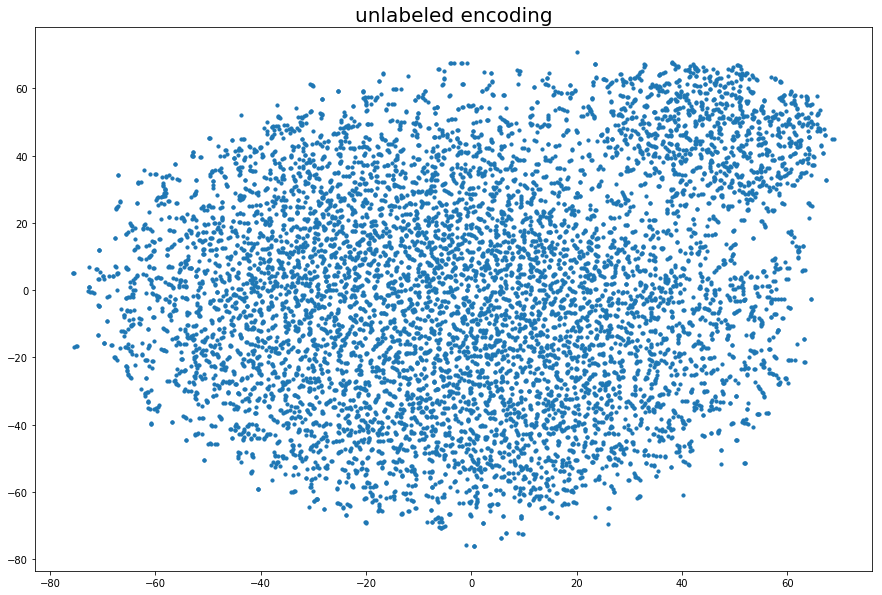

In [111]:
plot_tsne_df(tsne_df)

In [112]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [95]:
######################

In [113]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [114]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [115]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  MRD       -2.033333  134.156400        20.666667  149.133333
1  LMF        2.833333  130.509200        21.666667  173.166667
2  SAW        0.033333  114.788367        18.000000  135.133333
3  CIK        1.033333  114.824267        20.000000  147.933333
4  SYW       -1.000000  145.486833        21.666667  170.133333

In [116]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  MRD       -2.033333  134.156400        20.666667  149.133333 -24.060385   
1  LMF        2.833333  130.509200        21.666667  173.166667  39.735126   
2  SAW        0.033333  114.788367        18.000000  135.133333 -31.276781   
3  CIK        1.033333  114.824267        20.000000  147.933333  -8.633713   
4  SYW       -1.000000  145.486833        21.666667  170.133333  16.072727   

          x1  
0  48.666458  
1  11.575704  
2  16.450603  
3 -15.678930  
4 -60.320328

In [117]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

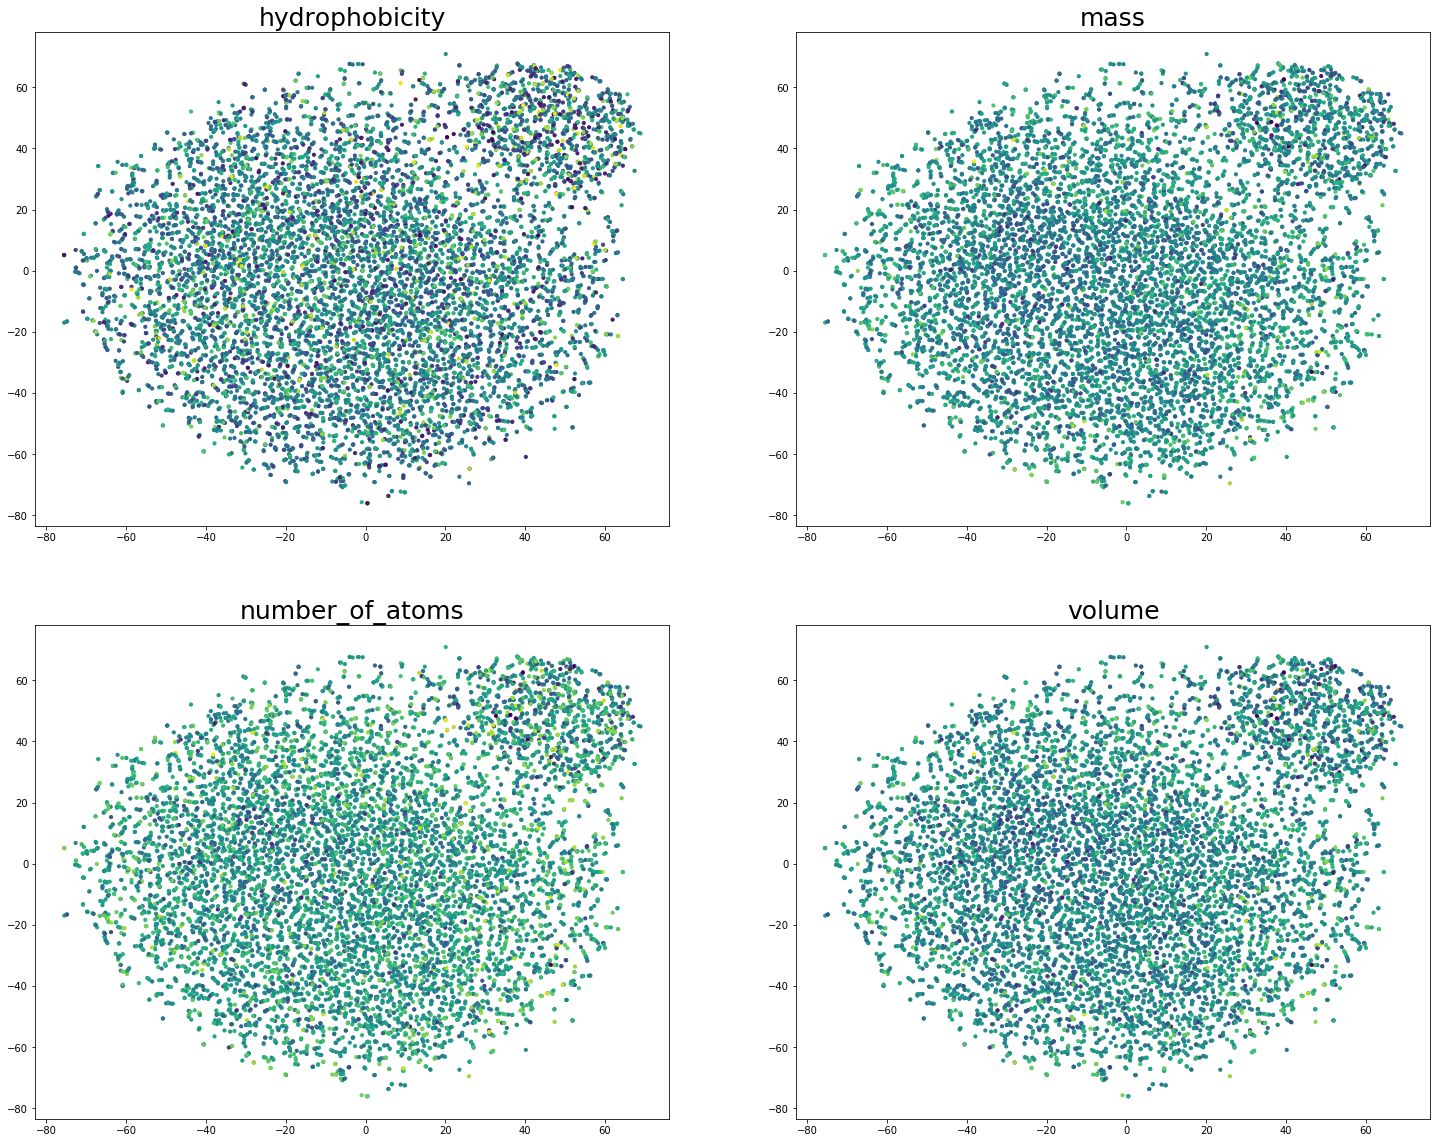

In [118]:
plot_embedding_properties(final_df)

In [28]:
######################

In [62]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

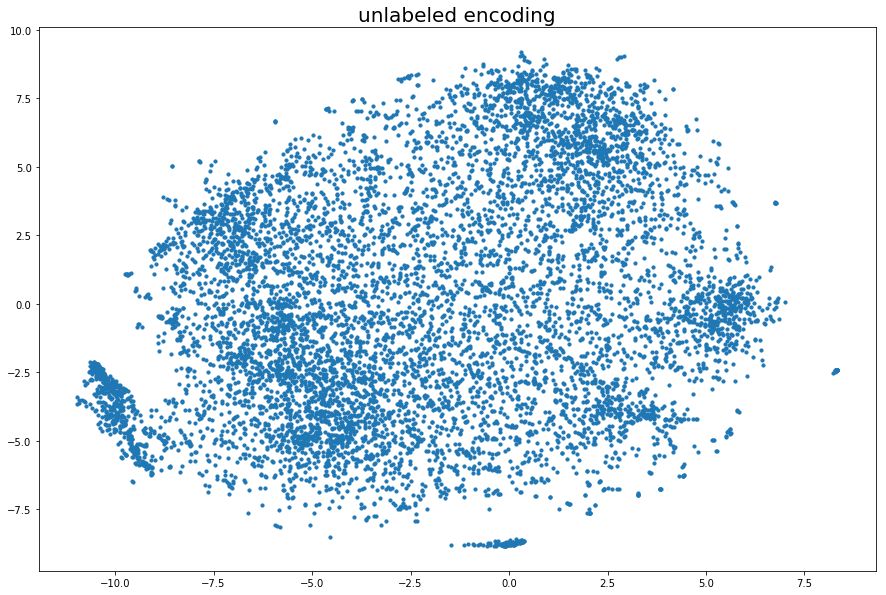

In [63]:
plot_tsne_df(gensim_tsne_df)

In [64]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

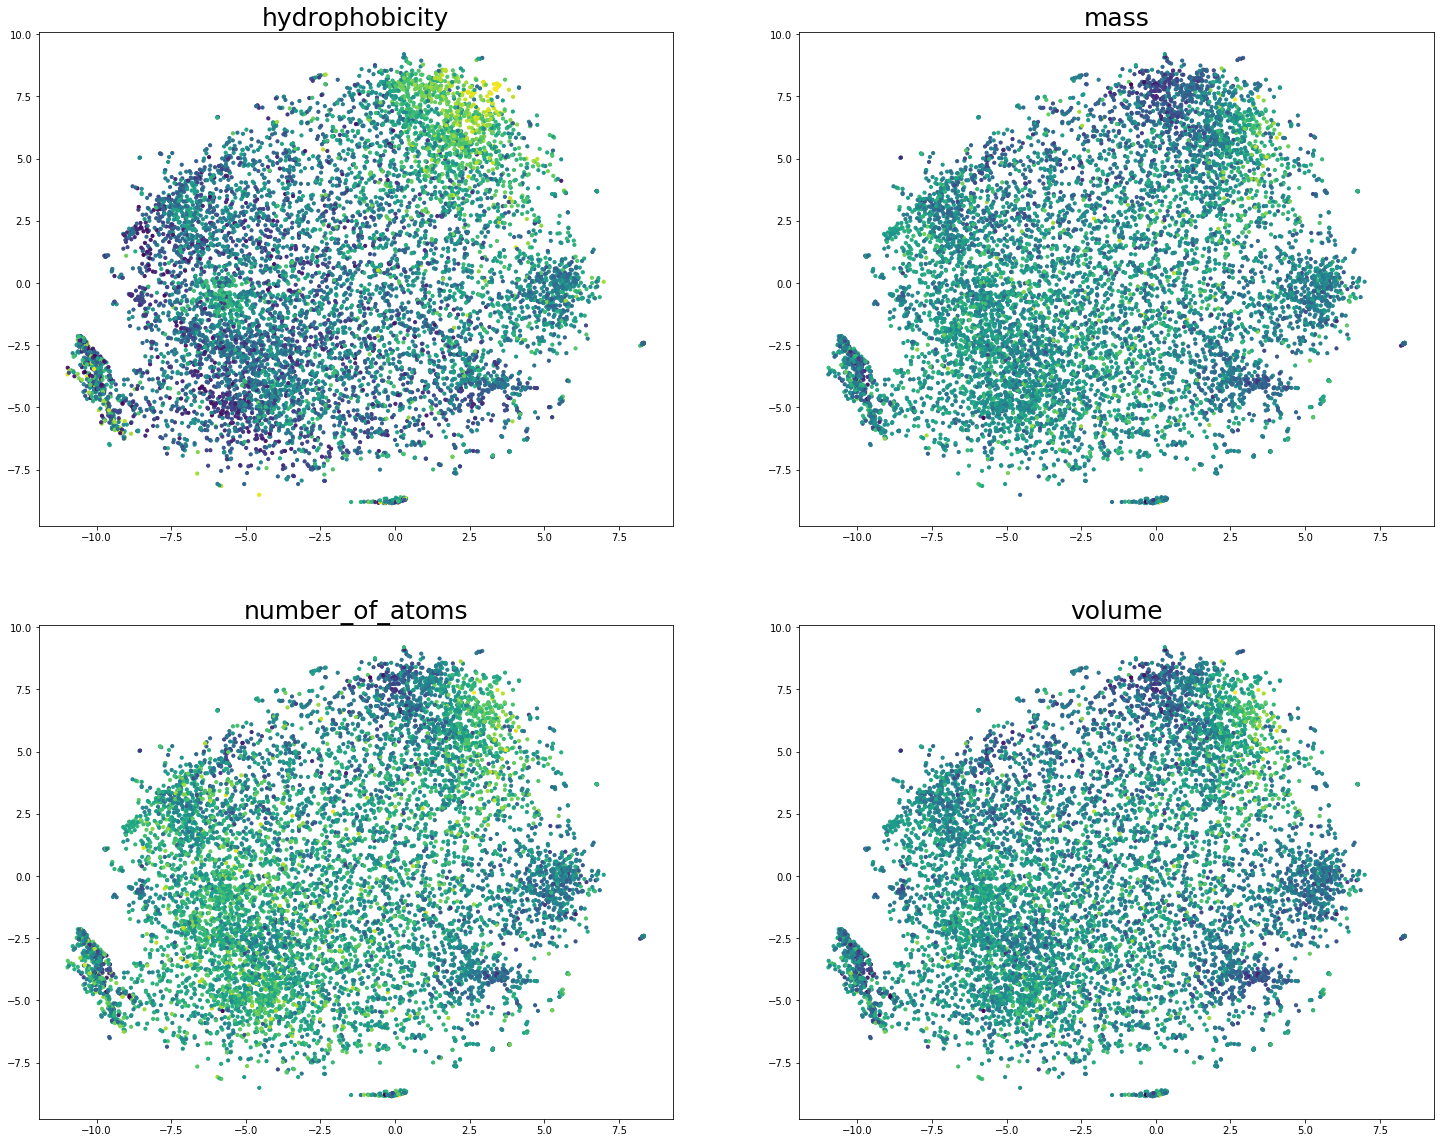

In [65]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/